# Imports and data 

In [106]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Check for ecological fallacy

In [107]:
a = {}
a[15] = {}
a[15][1] = (1, 5, 9)
a[15][2] = (2, 8, 14)
a[10] = {}
a[10][1] = (1, 7, 13)
a[10][2] = (2, 12, 22)
a[7] = {}
a[7][1] = (1, 10, 19)
a[7][2] = (2, 17, 32)
a[5] = {}
a[5][1] = (2, 15, 28)
a[5][2] = (2, 23, 44)
a[3] = {}
a[3][1] = (4, 25, 46)
a[3][2] = (2, 40, 78)

In [109]:
ksp = {}
for c in ['uk', 'uk2', 'mit']:
    ksp[c] = {}
    for Da in a.keys():
        ksp[c][Da] = {}
        series = pc.get_fal(calls[c], 100, 150, Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][1][0]) & (df.index <= a[Da][1][1])]
            right = df.loc[(df.index >= a[Da][1][1]) & (df.index <= a[Da][1][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['m'] = ksp[c][Da].get('m', [])
                ksp[c][Da]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
        series = pc.get_fal(calls[c], 200, 250, Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][2][0]) & (df.index <= a[Da][2][1])]
            right = df.loc[(df.index >= a[Da][2][1]) & (df.index <= a[Da][2][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['l'] = ksp[c][Da].get('l', [])
                ksp[c][Da]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

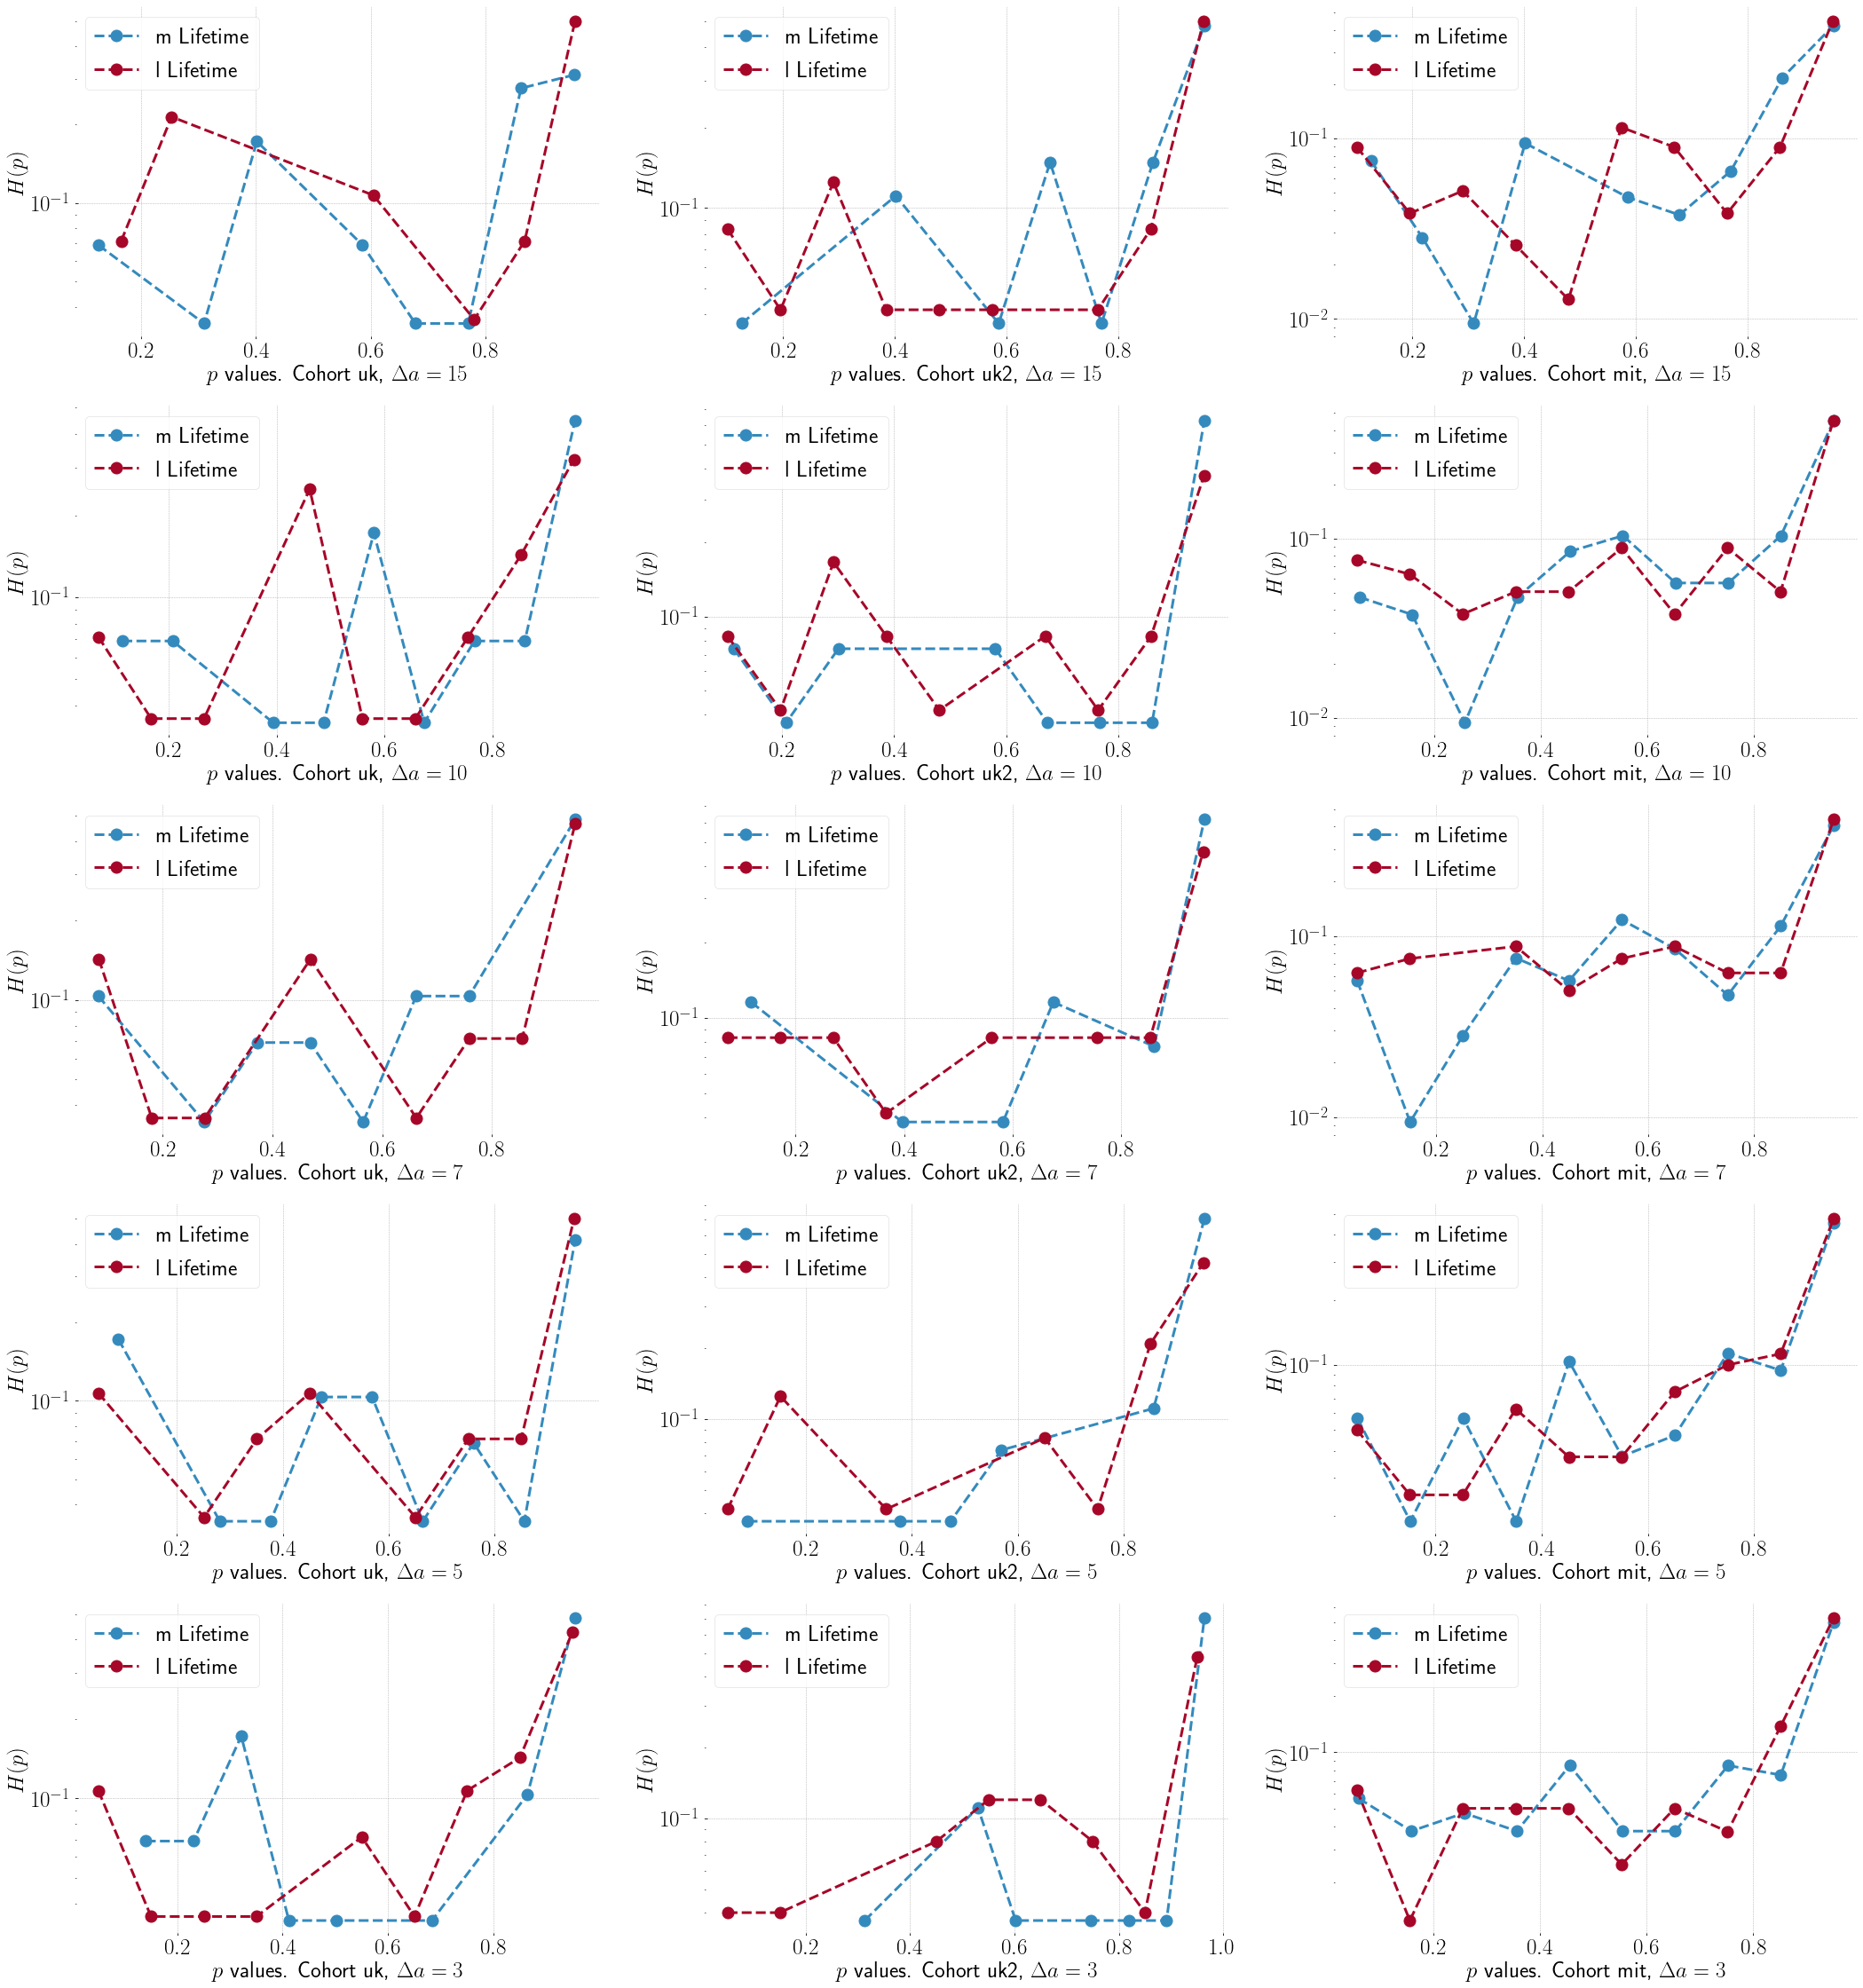

In [112]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in a.keys():
    for c in ksp.keys():
        plt.subplot(5, 3, p)
        plt.semilogy()
        plt.xlabel(fr"$p$ values. Cohort {c}, $\Delta a = {Da}$")
        plt.ylabel(r'$H(p)$')
        for s in ['m', 'l']:
            H = pc.histogram(ksp[c][Da][s], 10, log=False)
            plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, label=f"{s} Lifetime")
        plt.legend()
        p += 1
plt.savefig("/home/vsvh/Desktop/A.png", dpi=150, pad_inches=2)

# Explore relationship between $\ell$ and $b$

In [72]:
test = pc.get_fal(unfiltered['uk'], 200, 300, 15)

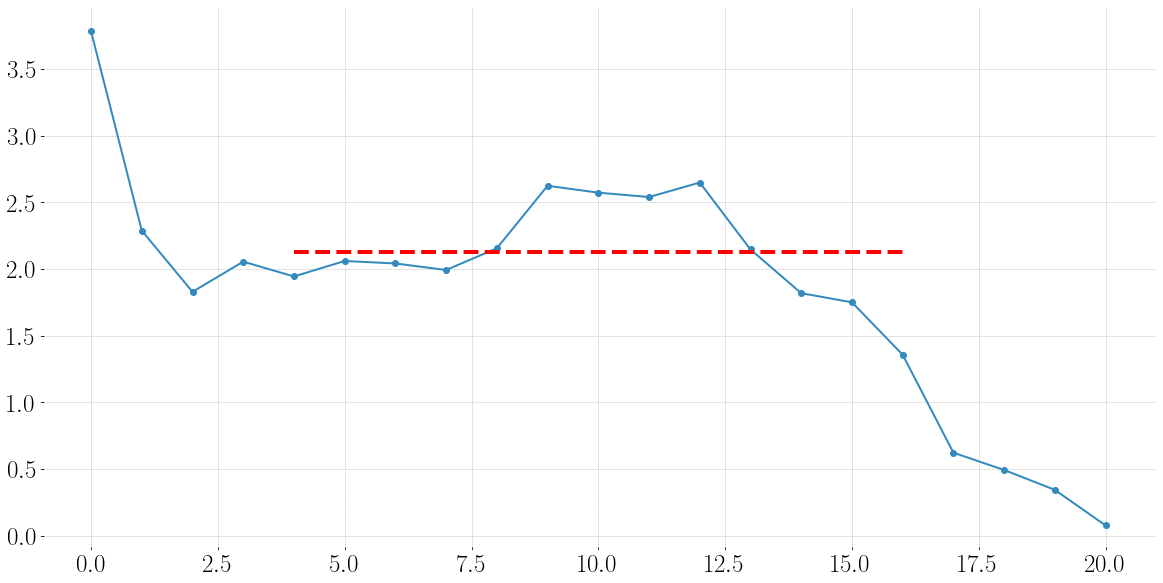

In [76]:
plt.plot(test['f'].index, test['f']['f'], "o-")
points = pc.get_plateau(test['f'])
plt.plot([x[0] for x in points], [y[1] for y in points], marker="", ls="dashed", lw=4, c="red")

In [104]:
fa = {}
for c in calls.keys():
    fa[c] = {}
    for ell in range(max(calls[c]['aclock'])):
        curve = pc.get_fal(calls[c], ell, ell + 30, 15)
        if (type(curve) == dict) and (len(curve['f']) > 5):
            points = pc.get_plateau(curve['f'], arbxo=1, arbxf=1)
            fa[c][ell] = points[0][1]
    fa[c] = pd.DataFrame.from_dict(fa[c], orient='index').sort_index()

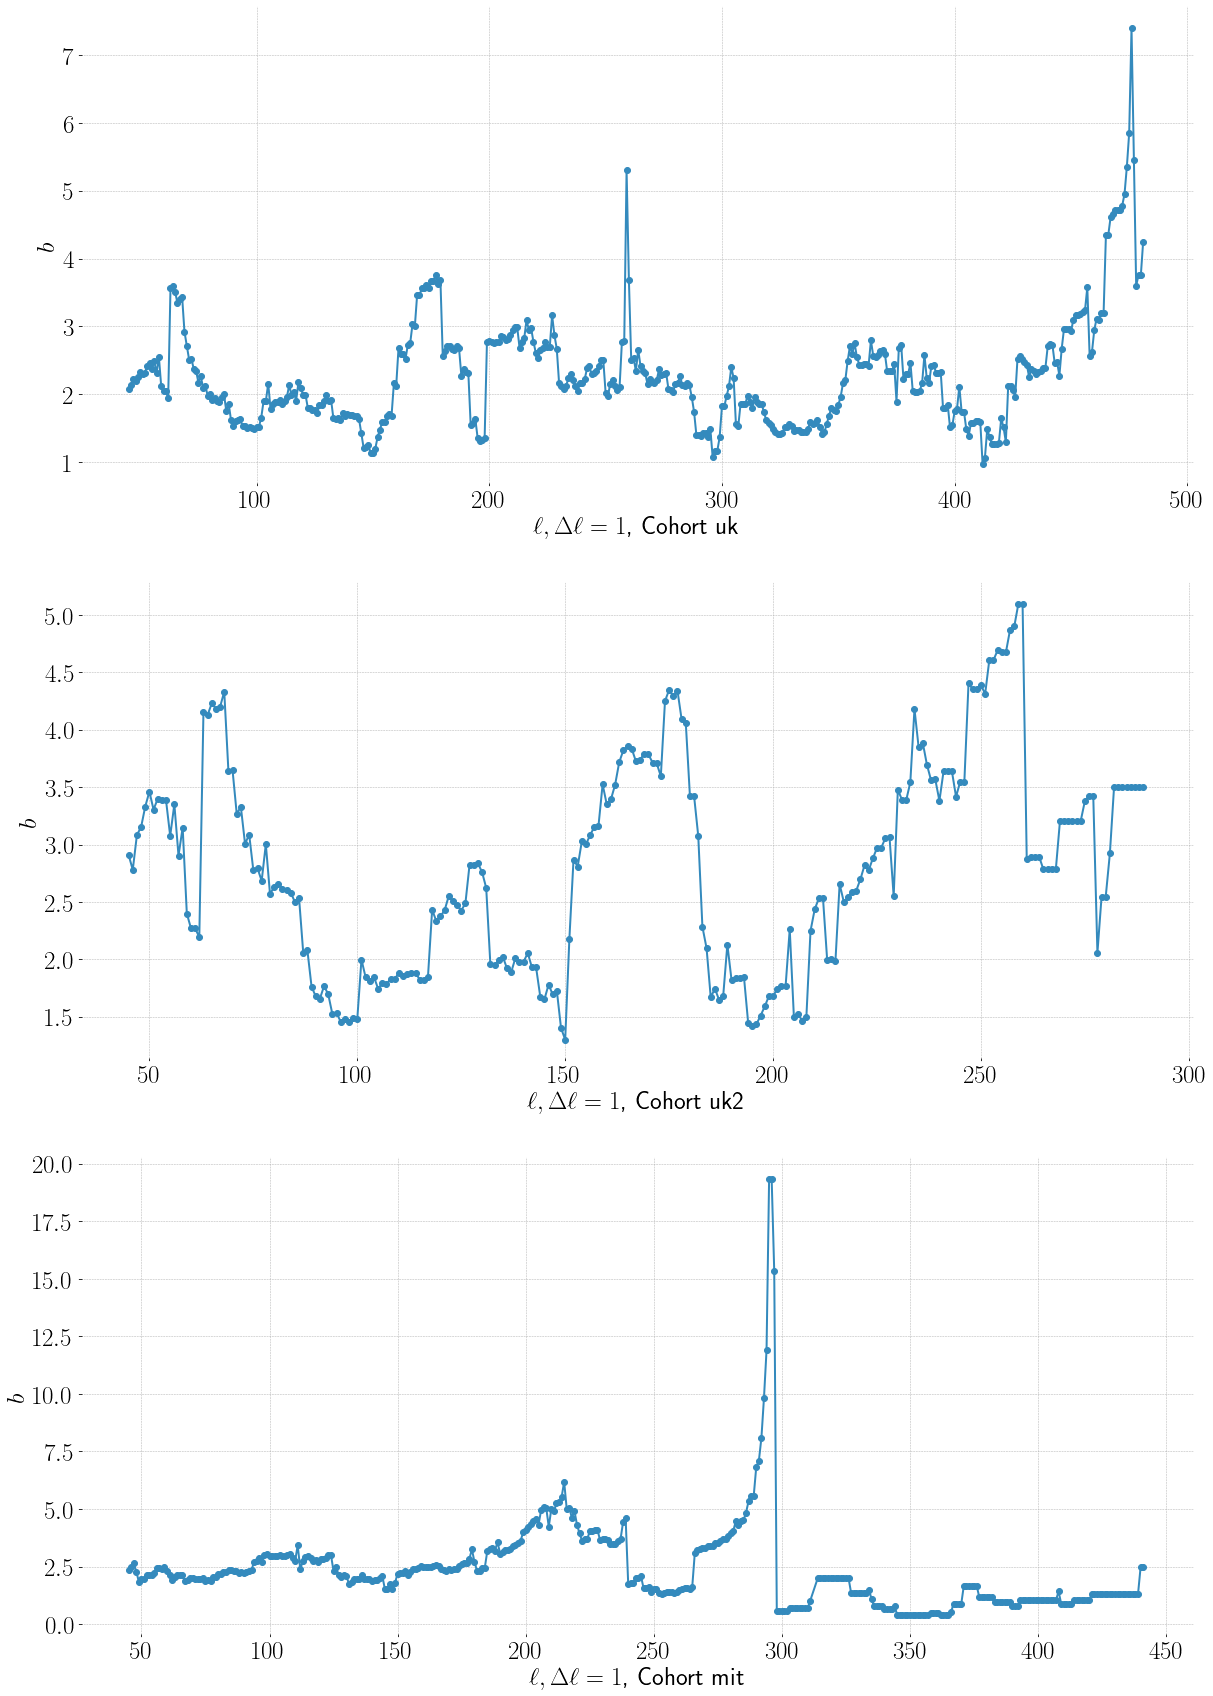

In [105]:
plt.figure(figsize=(20, 10*3))
p = 1
for c in fa.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(fr'$\ell, \Delta \ell = 1$, Cohort {c}')
    plt.ylabel(r'$b$')
    plt.plot(fa[c].index, fa[c][0], "o-")
    p += 1